In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import pandas.io.sql as pd_sql
from collections import Counter
from pprint import pprint
import pickle

In [110]:
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_validate, cross_val_predict
import imblearn.pipeline as impl

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

### Create SQL database in local server

CREATE DATABASE cancer;

\connect cancer;

CREATE TABLE cer_cancer(  
age INT,  
num_of_partner FLOAT,  
first_intercourse FLOAT,  
num_of_preg FLOAT,  
smokes FLOAT,  
smokes_years FLOAT,  
smokes_packs FLOAT,  
hormonal_contraceptives FLOAT,  
hormonal_contraceptives_years FLOAT,  
iud FLOAT,  
iud_years FLOAT,  
stds FLOAT,  
stds_num FLOAT,  
condylomatosis FLOAT,  
cervical_condylomatosis FLOAT,  
vaginal_condylomatosis FLOAT,  
vulvo_perineal_condylomatosis FLOAT,  
Syphilis FLOAT,  
pelvic_inflammation FLOAT,  
genital_herpes FLOAT,  
molluscum_contagiosum FLOAT,  
aids FLOAT,  
hiv FLOAT,  
hepatitis_b FLOAT,  
hpv FLOAT,  
num_of_stds FLOAT,  
time_since_std FLOAT,  
time_since_last_std FLOAT,  
dx_cancer INT,  
dx_cin INT,  
dx_hpv INT,  
dx INT,  
hinselmann INT,  
schiller INT,  
cytology INT,  
biopsy INT  
);  
  
    
\copy cer_cancer FROM '/Users/jsong/Documents/cancer_classification/cancer.csv' DELIMITER ',' CSV HEADER;


### Load data from SQL and EDA

In [4]:
connection_args = {
    'host': 'localhost',
    'dbname': 'cancer',
    'port': 5432
}

connection = pg.connect(**connection_args)

In [5]:
cursor = connection.cursor()

In [6]:
query = "SELECT * FROM cer_cancer;"

cancer = pd_sql.read_sql(query, connection)
cancer.head()

,age,num_of_partner,first_intercourse,num_of_preg,smokes,smokes_years,smokes_packs,hormonal_contraceptives,hormonal_contraceptives_years,iud,...,time_since_std,time_since_last_std,dx_cancer,dx_cin,dx_hpv,dx,hinselmann,schiller,cytology,biopsy
0,18,4.0,15.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
1,15,1.0,14.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
2,34,1.0,16.9953,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
3,52,5.0,16.0000,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0.0,1,0,1,0,0,0,0,0
4,46,3.0,21.0000,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0


In [7]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
age                              858 non-null int64
num_of_partner                   858 non-null float64
first_intercourse                858 non-null float64
num_of_preg                      858 non-null float64
smokes                           858 non-null float64
smokes_years                     858 non-null float64
smokes_packs                     858 non-null float64
hormonal_contraceptives          858 non-null float64
hormonal_contraceptives_years    858 non-null float64
iud                              858 non-null float64
iud_years                        858 non-null float64
stds                             858 non-null float64
stds_num                         858 non-null float64
condylomatosis                   858 non-null float64
cervical_condylomatosis          858 non-null float64
vaginal_condylomatosis           858 non-null float64
vulvo_perineal_condylomatosis    

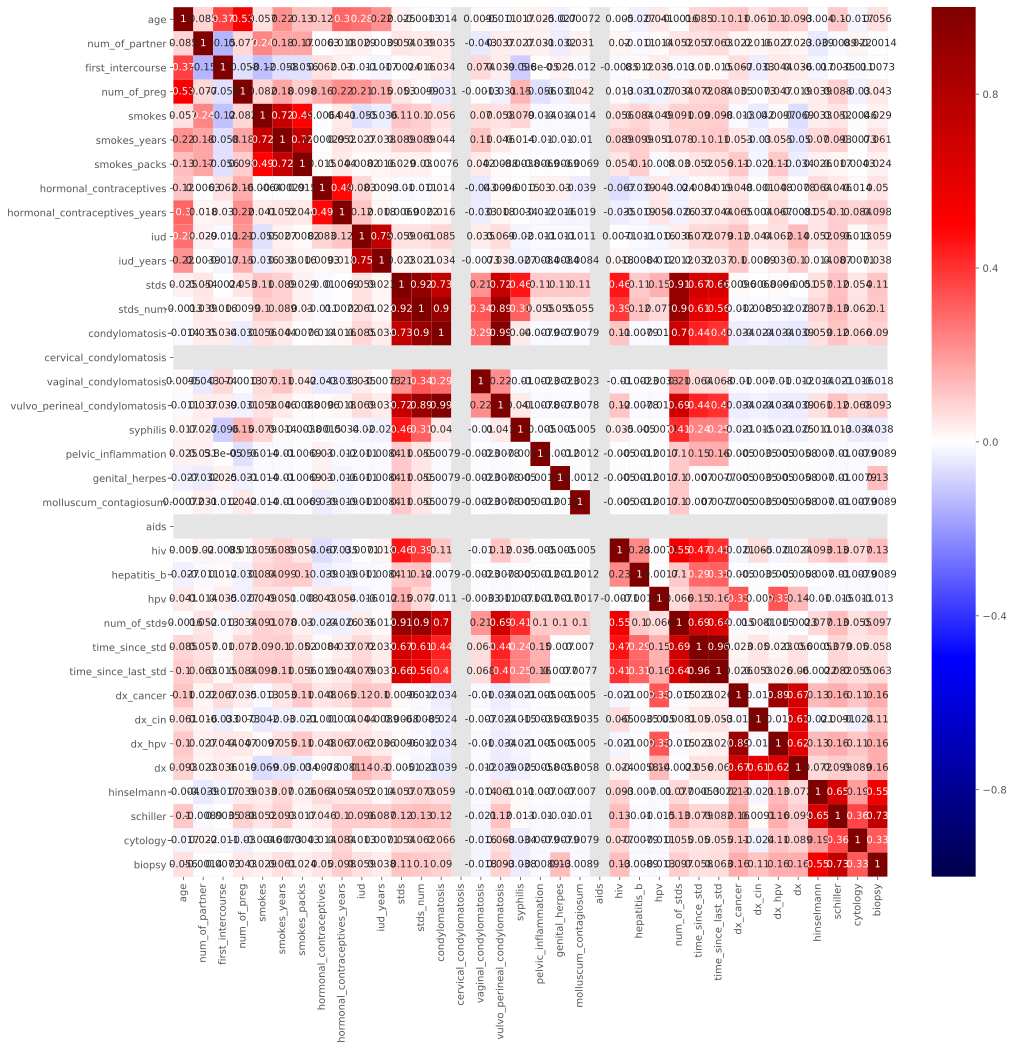

In [8]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(cancer.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

In [9]:
#delect the columns without values
del cancer['cervical_condylomatosis']
del cancer['aids']

### Model selction

0    803
1     55
Name: biopsy, dtype: int64
Percentage of Majority Class: 93.59


Text(23.875, 0.5, 'Number of case')

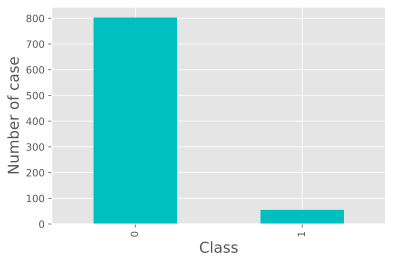

In [10]:
#check class imbalance
print(cancer['biopsy'].value_counts())
print('Percentage of Majority Class:', 
      round(cancer['biopsy'].value_counts()[0]/sum(cancer['biopsy'].value_counts())*100, 3))

fig=cancer['biopsy'].value_counts().plot(kind='bar', color='c')
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/class_imbalance.svg')
plt.xlabel('Class', size=15)
plt.ylabel('Number of case', size=15)

#### split train/test set and oversampling

In [11]:
X = cancer.iloc[:, :30]
y = cancer.loc[:, 'biopsy']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state=7, stratify = y)

In [12]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN(random_state=7).fit_sample(X_train, y_train)

In [13]:
#compare models
lr_model = linear_model.LogisticRegression(solver="lbfgs")
nb_model = naive_bayes.GaussianNB()
knn_model = neighbors.KNeighborsClassifier()
svc_model = svm.SVC(probability=True, gamma="scale")
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
et_model = ensemble.ExtraTreesClassifier(n_estimators=100)
ada_model = ensemble.AdaBoostClassifier()

models = ["lr_model", "nb_model", "knn_model", "svc_model", "rf_model", "et_model", "ada_model"]

In [14]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_adasyn, y_adasyn)
    
    with open(f"models/{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [15]:
# Load pre-trained/tuned models

model_names = ["lr_model", "nb_model", "knn_model", "svc_model", "rf_model", "et_model", "ada_model"]

for model_name in model_names:
    with open(f"models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [16]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} accuracy: {curr_model.score(X_test, y_test)}')

lr_model accuracy: 0.7151162790697675
nb_model accuracy: 0.11627906976744186
knn_model accuracy: 0.7151162790697675
svc_model accuracy: 0.7674418604651163
rf_model accuracy: 0.9244186046511628
et_model accuracy: 0.9127906976744186
ada_model accuracy: 0.8895348837209303


In [17]:
for model_name in model_names:
    curr_model = eval(model_name)
    y_pre = (curr_model.predict_proba(X_test)[:,1] > 0.5)
    print(f'{model_name} recall: {recall_score(y_test, y_pre)}')

lr_model recall: 0.5454545454545454
nb_model recall: 1.0
knn_model recall: 0.5454545454545454
svc_model recall: 0.2727272727272727
rf_model recall: 0.18181818181818182
et_model recall: 0.2727272727272727
ada_model recall: 0.09090909090909091


In [101]:
for model_name in model_names:
    curr_model = eval(model_name)
    y_pre = (curr_model.predict_proba(X_test)[:,1] > 0.5)
    print(f'{model_name} ROC_AUC score: {roc_auc_score(y_test, y_pre)}')

lr_model ROC_AUC score: 0.6360813099943534
nb_model ROC_AUC score: 0.5279503105590062
knn_model ROC_AUC score: 0.6360813099943534
svc_model ROC_AUC score: 0.4966120835686053
rf_model ROC_AUC score: 0.6693958215697347
et_model ROC_AUC score: 0.6662902315076229
ada_model ROC_AUC score: 0.5175042348955392


#### cross-validation

In [124]:
pipe = impl.Pipeline([
                    ('scaler', StandardScaler()),
                    ('oversampler', ADASYN()),
                    ('clf', lr_model)
                    ])
cross_val_score(pipe, X_train, y_train, cv=5)

scoring = ['roc_auc','recall']
scores=cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
sorted(scores.keys())

print('roc_auc:', scores['test_roc_auc'])
print('recall:', scores['test_recall'])

roc_auc: [0.5047373  0.59086994 0.57291667 0.5234375  0.68066406]
recall: [0.22222222 0.55555556 0.55555556 0.44444444 0.5       ]


In [127]:
pipe = impl.Pipeline([
                    ('scaler', StandardScaler()),
                    ('oversampler', ADASYN()),
                    ('clf', nb_model)
                    ])
cross_val_score(pipe, X_train, y_train, cv=5)

scoring = ['roc_auc','recall']
scores=cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
sorted(scores.keys())

print('roc_auc:', scores['test_roc_auc'])
print('recall:', scores['test_recall'])

roc_auc: [0.55211025 0.52713178 0.49305556 0.40928819 0.68652344]
recall: [1.         1.         0.88888889 0.88888889 1.        ]


In [128]:
pipe = impl.Pipeline([
                    ('scaler', StandardScaler()),
                    ('oversampler', ADASYN()),
                    ('clf', knn_model)
                    ])
cross_val_score(pipe, X_train, y_train, cv=5)

scoring = ['roc_auc','recall']
scores=cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
sorted(scores.keys())
result_AUC.append(scores['test_roc_auc'].mean())
result_recall.append(scores['test_recall'].mean())

print('roc_auc:', scores['test_roc_auc'])
print('recall:', scores['test_recall'])

roc_auc: [0.50990525 0.50172265 0.65842014 0.66710069 0.61572266]
recall: [0.11111111 0.33333333 0.44444444 0.33333333 0.375     ]


In [129]:
pipe = impl.Pipeline([
                    ('scaler', StandardScaler()),
                    ('oversampler', ADASYN()),
                    ('clf', svc_model)
                    ])
cross_val_score(pipe, X_train, y_train, cv=5)

scoring = ['roc_auc','recall']
scores=cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
sorted(scores.keys())

print('roc_auc:', scores['test_roc_auc'])
print('recall:', scores['test_recall'])

roc_auc: [0.50215332 0.4496124  0.66753472 0.58072917 0.49511719]
recall: [0.22222222 0.22222222 0.33333333 0.33333333 0.25      ]


In [130]:
pipe = impl.Pipeline([
                    ('scaler', StandardScaler()),
                    ('oversampler', ADASYN()),
                    ('clf', rf_model)
                    ])
cross_val_score(pipe, X_train, y_train, cv=5)

scoring = ['roc_auc','recall']
scores=cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
sorted(scores.keys())

print('roc_auc:', scores['test_roc_auc'])
print('recall:', scores['test_recall'])

roc_auc: [0.59474591 0.56804479 0.61197917 0.64496528 0.63183594]
recall: [0.         0.22222222 0.         0.11111111 0.        ]


In [131]:
pipe = impl.Pipeline([
                    ('scaler', StandardScaler()),
                    ('oversampler', ADASYN()),
                    ('clf', et_model)
                    ])
cross_val_score(pipe, X_train, y_train, cv=5)

scoring = ['roc_auc','recall']
scores=cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
sorted(scores.keys())

print('roc_auc:', scores['test_roc_auc'])
print('recall:', scores['test_recall'])

roc_auc: [0.52024117 0.54952627 0.65798611 0.74262153 0.60839844]
recall: [0.         0.11111111 0.11111111 0.11111111 0.125     ]


In [132]:
pipe = impl.Pipeline([
                    ('scaler', StandardScaler()),
                    ('oversampler', ADASYN()),
                    ('clf', ada_model)
                    ])
cross_val_score(pipe, X_train, y_train, cv=5)

scoring = ['roc_auc','recall']
scores=cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
sorted(scores.keys())

print('roc_auc:', scores['test_roc_auc'])
print('recall:', scores['test_recall'])

roc_auc: [0.59732989 0.59302326 0.59678819 0.54730903 0.55224609]
recall: [0.22222222 0.22222222 0.11111111 0.11111111 0.        ]


Naive Bayes = best in terms of recall score  
Random Forest / Extra Trees = best in terms of accuracy

In [26]:
nb_model.fit(X_adasyn, y_adasyn)

GaussianNB(priors=None, var_smoothing=1e-09)

In [27]:
rf_model.fit(X_adasyn, y_adasyn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
et_model.fit(X_adasyn, y_adasyn)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

ROC AUC score for RF model =  0.7922077922077922
ROC AUC score for ET model =  0.8088650479954829
ROC AUC score for NB model =  0.6764539808018069


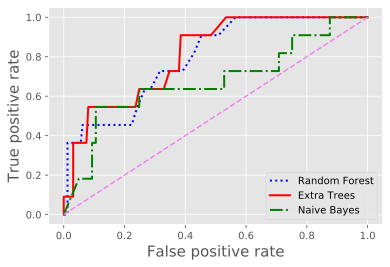

In [99]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, et_model.predict_proba(X_test)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1])

plt.plot(fpr1, tpr1,lw=2,ls=':',c='blue',label='Random Forest')
plt.plot(fpr2, tpr2,lw=2,c='red',label='Extra Trees')
plt.plot(fpr3, tpr3,lw=2,ls='-.',c='green',label='Naive Bayes')


plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', size=15)
plt.ylabel('True positive rate', size=15)
plt.legend(loc='lower right')

print("ROC AUC score for RF model = ", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))
print("ROC AUC score for ET model = ", roc_auc_score(y_test, et_model.predict_proba(X_test)[:,1]))
print("ROC AUC score for NB model = ", roc_auc_score(y_test, nb_model.predict_proba(X_test)[:,1]))
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/roc-1.svg')

In [31]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='GnBu')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', size=25)
    plt.xlabel('Predicted label', size=25)
    return fig

In [32]:
y_predict_nb=nb_model.predict(X_test)
print(recall_score(y_test, y_predict_nb))

1.0


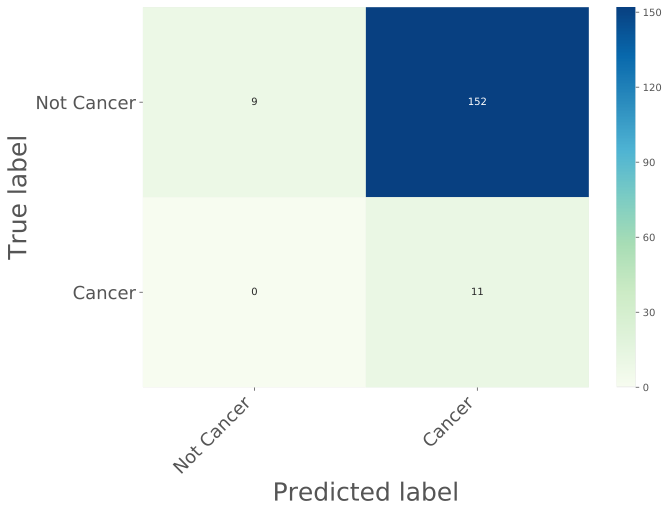

In [33]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_predict_nb), ['Not Cancer', 'Cancer'])
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/cm_nb.svg')

Text(0.5, 1.0, 'Precision and Recall Curves')

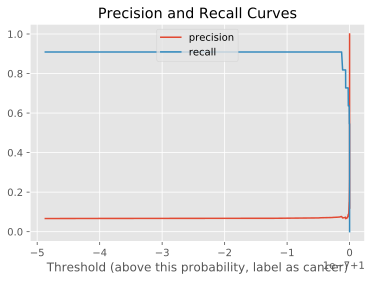

In [34]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, nb_model.predict_proba(X_test)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper center')
plt.xlabel('Threshold (above this probability, label as cancer)')
plt.title('Precision and Recall Curves')

In [35]:
y_predict_rf=rf_model.predict(X_test)
print(recall_score(y_test, y_predict_rf))

0.18181818181818182


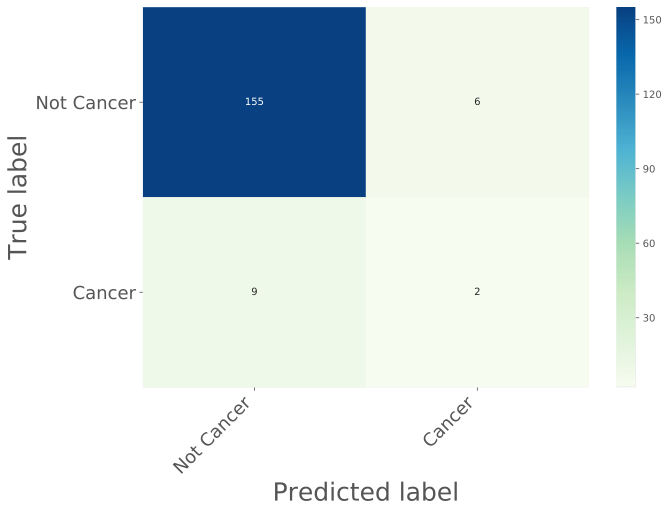

In [36]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_predict_rf), ['Not Cancer', 'Cancer'])
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/cm_rf.svg')

Text(0.5, 1.0, 'Precision and Recall Curves')

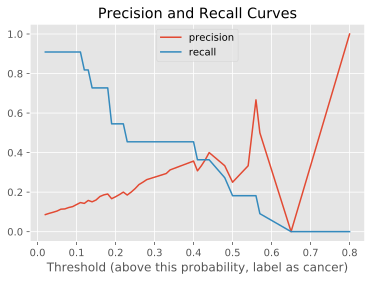

In [37]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper center')
plt.xlabel('Threshold (above this probability, label as cancer)')
plt.title('Precision and Recall Curves')

In [38]:
y_predict_et=et_model.predict(X_test)
print(recall_score(y_test, y_predict_et))

0.2727272727272727


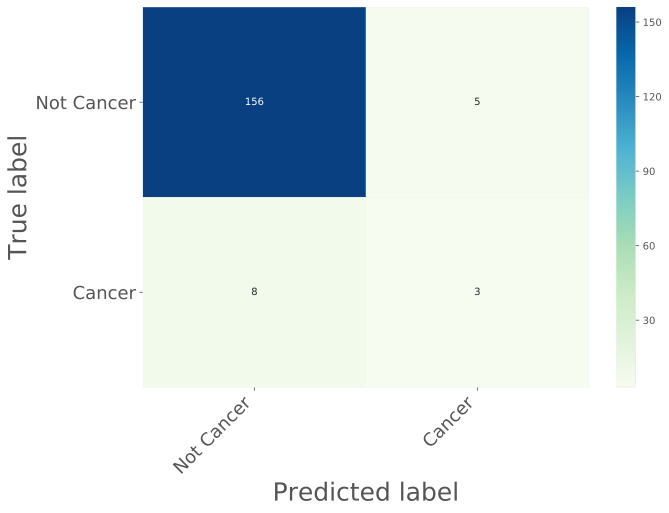

In [39]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_predict_et), ['Not Cancer', 'Cancer'])
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/cm_et.svg')

Text(0.5, 1.0, 'Precision and Recall Curves')

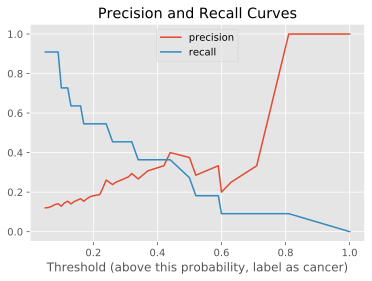

In [40]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, et_model.predict_proba(X_test)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper center')
plt.xlabel('Threshold (above this probability, label as cancer)')
plt.title('Precision and Recall Curves')

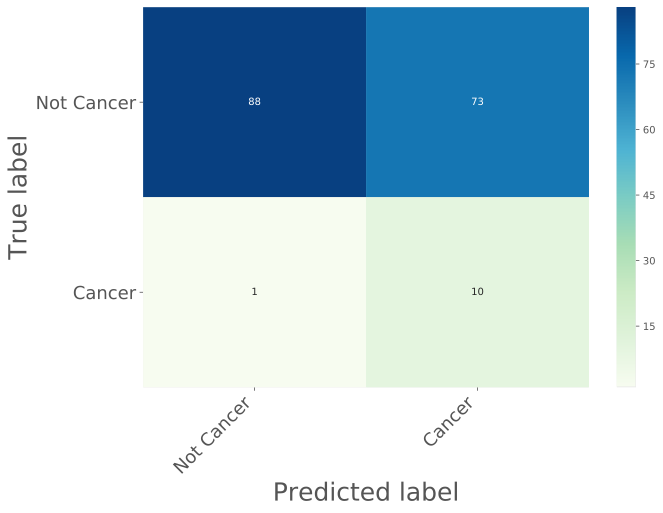

In [48]:
cm = print_confusion_matrix(confusion_matrix(y_test, et_model.predict_proba(X_test)[:,1]>0.05), ['Not Cancer', 'Cancer'])
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/cm_et_3.svg')

In [136]:
roc_auc_score(y_test, et_model.predict_proba(X_test)[:,1]>0.05)

0.7309429700734049

In [41]:
# search multiple parameters simultaneously - this will take a while
et_model1=ensemble.ExtraTreesClassifier()
max_depth_range = range(1, 11)
leaf_range = range(1, 11)
estimator=[100, 300, 500]
param_grid = dict(n_estimators=estimator,
                  max_depth=max_depth_range,
                  min_samples_leaf=leaf_range)
grid = GridSearchCV(et_model1,
                     param_grid,
                     cv=5,
                     scoring='recall',
                     return_train_score=True,
                     n_jobs=-1)
grid.fit(X_adasyn, y_adasyn)

print(grid.cv_results_)

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'mean_fit_time': array([0.1414557 , 0.43438215, 0.74083481, 0.14614811, 0.44234209,
       0.84871597, 0.1800334 , 0.46309609, 0.81070738, 0.15676985,
       0.55822306, 0.75094213, 0.14763703, 0.45343227, 0.75897789,
       0.1512702 , 0.45765142, 0.76204972, 0.15471239, 0.46336851,
       0.84888649, 0.15556898, 0.54672356, 0.82914472, 0.16544518,
       0.49891133, 0.83108792, 0.16784639, 0.49720783, 0.83991618,
       0.17472396, 0.51770806, 0.83500476, 0.16880627, 0.5050262 ,
       0.843822  , 0.16599422, 0.59710531, 0.90363412, 0.1716661 ,
       0.50064178, 0.90641379, 0.1757154 , 0.65249634, 0.92870054,
       0.18226776, 0.53888192, 0.91795516, 0.18014655, 0.52768369,
       0.85203662, 0.16653976, 0.51197248, 0.8687099 , 0.17238674,
       0.51858015, 0.87176619, 0.18165102, 0.53782301, 0.91118698,
       0.17809458, 0.67194066, 1.155619  , 0.20418506, 0.63059468,
       0.9544342 , 0.18701506, 0.59974961, 1.00089841, 0.1955368 ,
       0.61271062, 1.12901831, 0.22515502, 0

In [50]:
print(grid.best_score_)
print(grid.best_params_)

0.6978845608164304
{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}


In [51]:
et_model2 = ensemble.ExtraTreesClassifier(n_estimators=100, max_depth=10, min_samples_leaf=1)
et_model2.fit(X_adasyn, y_adasyn)
y_predict_et2 = et_model2.predict(X_test)

In [52]:
print(recall_score(y_test, y_predict_et2))
print(et_model2.score(X_test, y_test))
print(roc_auc_score(y_test, (et_model2.predict(X_test))))

0.18181818181818182
0.9127906976744186
0.5722755505364201


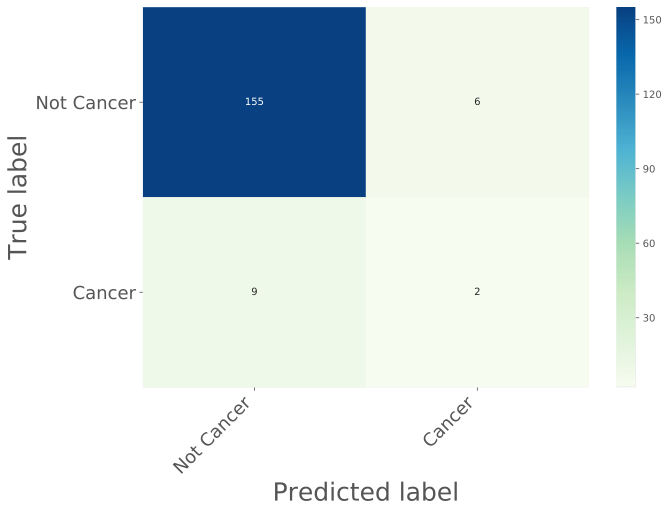

In [53]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_predict_et2), ['Not Cancer', 'Cancer'])
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/cm_et_2.svg')

Text(0.5, 1.0, 'Precision and Recall Curves')

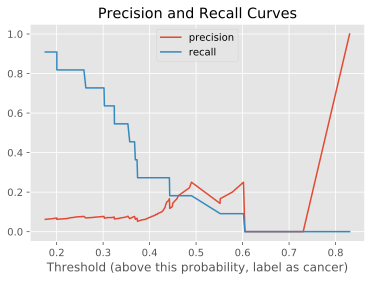

In [54]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, et_model2.predict_proba(X_test)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper center')
plt.xlabel('Threshold (above this probability, label as cancer)')
plt.title('Precision and Recall Curves')

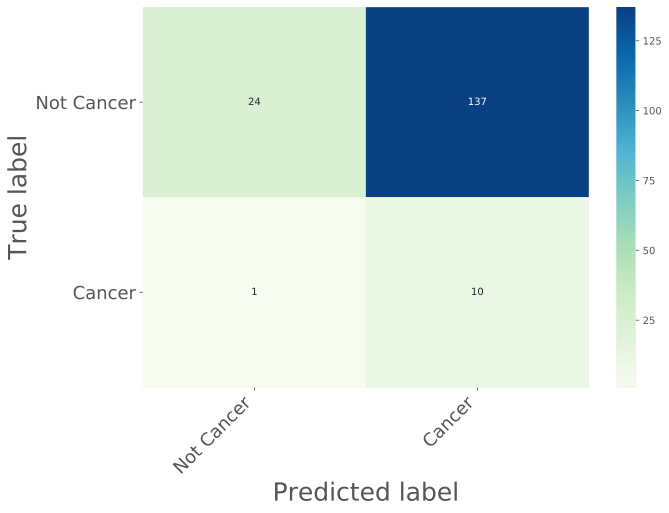

In [55]:
cm = print_confusion_matrix(confusion_matrix(y_test, et_model2.predict_proba(X_test)[:,1]>0.2), ['Not Cancer', 'Cancer'])
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/cm_et_4.svg')

In [108]:
print(f'Train R^2 Score: {np.round(et_model.score(X_adasyn, y_adasyn), 4)}')
print(f'Test R^2 Score: {np.round(et_model.score(X_test, y_test), 4)}')

Train R^2 Score: 0.9992
Test R^2 Score: 0.9302


In [112]:
def bias_metric(y_true, y_pred):
    return np.mean((np.mean(y_pred) - y_true)**2)

def variance_metric(y_true, y_pred):
    return np.var(y_true - y_pred)

In [113]:
variance = []
bias = []
test_range = np.arange(1, 30, 1)

for i in test_range:
    cv_out = cross_validate(
        estimator=BaggingRegressor(
            ExtraTreesClassifier(random_state=7), n_estimators=i),
        X=X_adasyn,
        y=y_adasyn,
        cv=3,
        return_train_score=True,
        scoring={
            "variance": make_scorer(variance_metric),
            "bias": make_scorer(bias_metric)
        },
        n_jobs=-1,
    )
    variance.append(np.mean(cv_out['test_variance']))
    bias.append(np.mean(cv_out['test_bias']))

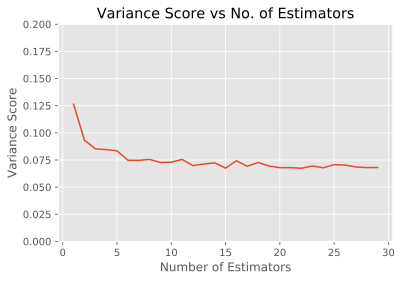

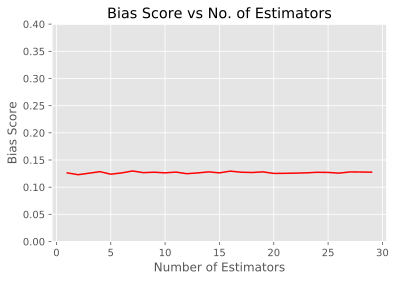

In [117]:
plt.figure(dpi=150)
plt.plot(test_range, variance, label='variance')
plt.ylim((0, 0.2))
plt.xlabel('Number of Estimators')
plt.ylabel('Variance Score');
plt.title('Variance Score vs No. of Estimators');

plt.figure(dpi=150)
plt.plot(test_range, bias, label='bias', c='r')
plt.ylim((0, 0.4))
plt.xlabel('Number of Estimators')
plt.ylabel('Bias Score');
plt.title('Bias Score vs No. of Estimators');

In [119]:
variance = []
bias = []
test_range = np.arange(1, 30, 1)

for i in test_range:
    cv_out = cross_validate(
        estimator=BaggingRegressor(
            RandomForestClassifier(random_state=7), n_estimators=i),
        X=X_adasyn,
        y=y_adasyn,
        cv=3,
        return_train_score=True,
        scoring={
            "variance": make_scorer(variance_metric),
            "bias": make_scorer(bias_metric)
        },
        n_jobs=-1,
    )
    variance.append(np.mean(cv_out['test_variance']))
    bias.append(np.mean(cv_out['test_bias']))

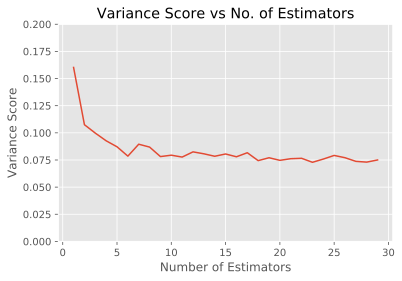

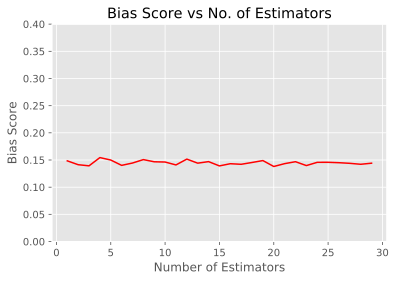

In [120]:
plt.figure(dpi=150)
plt.plot(test_range, variance, label='variance')
plt.ylim((0, 0.2))
plt.xlabel('Number of Estimators')
plt.ylabel('Variance Score');
plt.title('Variance Score vs No. of Estimators');

plt.figure(dpi=150)
plt.plot(test_range, bias, label='bias', c='r')
plt.ylim((0, 0.4))
plt.xlabel('Number of Estimators')
plt.ylabel('Bias Score');
plt.title('Bias Score vs No. of Estimators');

In [56]:
models1 = ["nb_model", "rf_model", "et_model"]

In [57]:
for model_name1 in models1:
    
    curr_model1 = eval(model_name1)
    
    curr_model1.fit(X_adasyn, y_adasyn)
    
    with open(f"models/{model_name1}.pickle", "wb") as pfile:
        pickle.dump(curr_model1, pfile)

In [58]:
# Load pre-trained/tuned models

model_names1 = ["nb_model", "rf_model", "et_model"]

for model_name1 in model_names1:
    with open(f"models/{model_name1}.pickle", "rb") as pfile:
        exec(f"{model_name1} = pickle.load(pfile)")

model_vars1 = [eval(n) for n in model_names1]
model_list1 = list(zip(model_names1, model_vars1))

In [59]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list1,
                                    voting='soft',
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('nb_model',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('rf_model',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                      

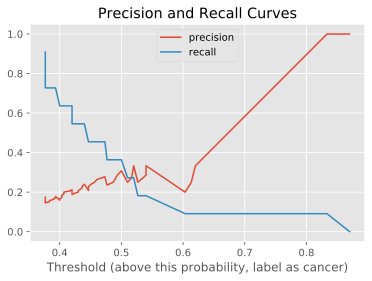

In [60]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, voting_classifer.predict_proba(X_test)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper center')
plt.xlabel('Threshold (above this probability, label as cancer)');
plt.title('Precision and Recall Curves');

In [61]:
y_predict_v = (voting_classifer.predict_proba(X_test)[:,1] > 0.37)
print('recall:', recall_score(y_test, y_predict_v))
print('accuracy:', accuracy_score(y_test, y_predict_v))
print('AUC:', roc_auc_score(y_test, y_predict_v))

recall: 1.0
accuracy: 0.7093023255813954
AUC: 0.84472049689441


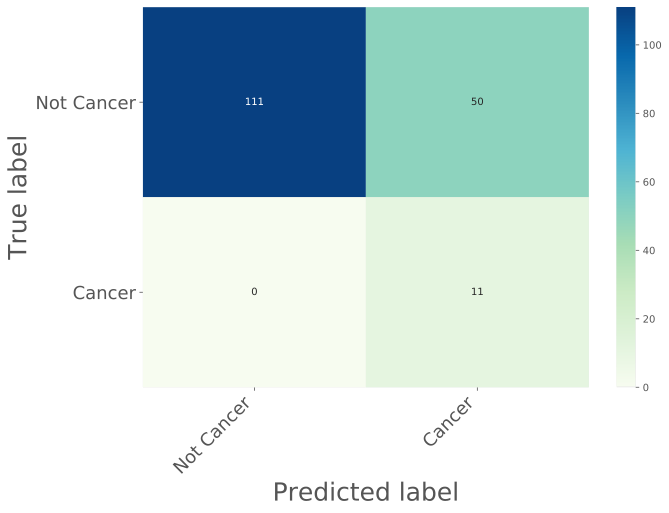

In [62]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_predict_v), ['Not Cancer', 'Cancer'])
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/cm_vc_05.svg')

In [137]:
roc_auc_score(y_test, y_predict_v)

0.84472049689441

In [63]:
models2 = ["lr_model", "nb_model", "rf_model"]

In [64]:
for model_name2 in models2:
    
    curr_model2 = eval(model_name2)
    
    curr_model2.fit(X_adasyn, y_adasyn)
    
    with open(f"models/{model_name2}.pickle", "wb") as pfile:
        pickle.dump(curr_model2, pfile)

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [65]:
# Load pre-trained/tuned models

model_names2 = ["lr_model", "nb_model", "rf_model"]

for model_name2 in model_names2:
    with open(f"models/{model_name2}.pickle", "rb") as pfile:
        exec(f"{model_name2} = pickle.load(pfile)")

model_vars2 = [eval(n) for n in model_names2]
model_list2 = list(zip(model_names2, model_vars2))

In [66]:
# create voting classifier
voting_classifer2 = VotingClassifier(estimators=model_list2,
                                    voting='soft',
                                    n_jobs=-1)
voting_classifer2.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('nb_model',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('rf_model',
                              Ran...
                                                     class_weight=None,
              

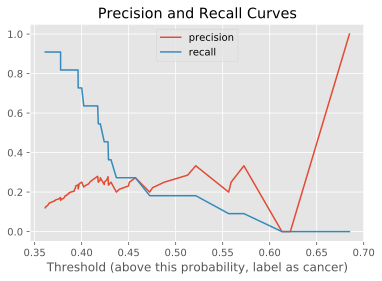

In [67]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, voting_classifer2.predict_proba(X_test)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper center')
plt.xlabel('Threshold (above this probability, label as cancer)');
plt.title('Precision and Recall Curves');

In [68]:
y_predict_v2 = (voting_classifer2.predict_proba(X_test)[:,1] > 0.35)
print('recall:', recall_score(y_test, y_predict_v2))
print('accuracy:', accuracy_score(y_test, y_predict_v2))
print('AUC:', roc_auc_score(y_test, y_predict_v2))

recall: 1.0
accuracy: 0.3430232558139535
AUC: 0.6490683229813665


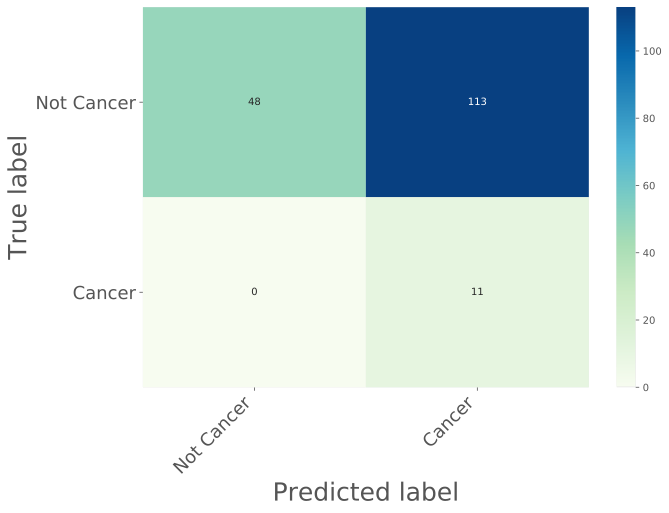

In [69]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_predict_v2), ['Not Cancer', 'Cancer'])
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/cm_vc_06.svg')

In [70]:
models3 = ["lr_model", "nb_model", "rf_model", "et_model"]

In [71]:
for model_name3 in models3:
    
    curr_model3 = eval(model_name3)
    
    curr_model3.fit(X_adasyn, y_adasyn)
    
    with open(f"models/{model_name3}.pickle", "wb") as pfile:
        pickle.dump(curr_model3, pfile)

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [72]:
# Load pre-trained/tuned models

model_names3 = ["lr_model", "nb_model", "rf_model", "et_model"]

for model_name3 in model_names3:
    with open(f"models/{model_name3}.pickle", "rb") as pfile:
        exec(f"{model_name3} = pickle.load(pfile)")

model_vars3 = [eval(n) for n in model_names3]
model_list3 = list(zip(model_names3, model_vars3))

In [73]:
# create voting classifier
voting_classifer3 = VotingClassifier(estimators=model_list3,
                                    voting='soft',
                                    n_jobs=-1)
voting_classifer3.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('nb_model',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('rf_model',
                              Ran...
                                                   class_weight=None,
                

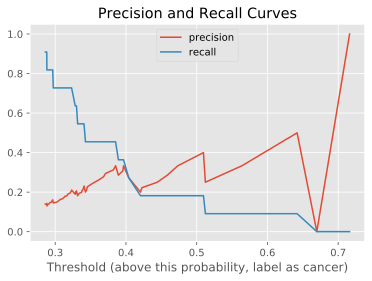

In [74]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, voting_classifer3.predict_proba(X_test)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper center')
plt.xlabel('Threshold (above this probability, label as cancer)');
plt.title('Precision and Recall Curves');

In [78]:
y_predict_v3 = (voting_classifer3.predict_proba(X_test)[:,1] > 0.2)
print('recall:', recall_score(y_test, y_predict_v3))
print('accuracy:', accuracy_score(y_test, y_predict_v3))
print('AUC:', roc_auc_score(y_test, y_predict_v3))

recall: 1.0
accuracy: 0.11627906976744186
AUC: 0.5279503105590062


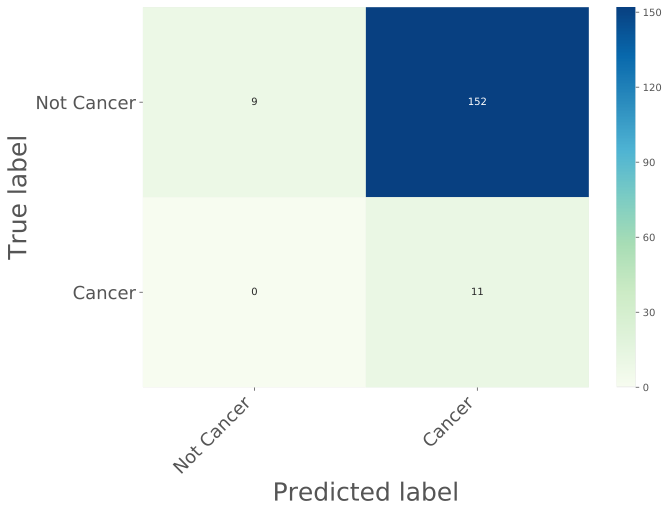

In [79]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_predict_v3), ['Not Cancer', 'Cancer'])
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/cm_vc_07.svg')

In [80]:
models4 = ["lr_model", "nb_model", "rf_model", "et_model", "ada_model"]

In [81]:
for model_name4 in models4:
    
    curr_model4 = eval(model_name4)
    
    curr_model4.fit(X_adasyn, y_adasyn)
    
    with open(f"models/{model_name4}.pickle", "wb") as pfile:
        pickle.dump(curr_model4, pfile)

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [82]:
# Load pre-trained/tuned models

model_names4 = ["lr_model", "nb_model", "rf_model", "et_model", "ada_model"]

for model_name4 in model_names4:
    with open(f"models/{model_name4}.pickle", "rb") as pfile:
        exec(f"{model_name4} = pickle.load(pfile)")

model_vars4 = [eval(n) for n in model_names4]
model_list4 = list(zip(model_names4, model_vars4))

In [83]:
# create voting classifier
voting_classifer4 = VotingClassifier(estimators=model_list4,
                                    voting='soft',
                                    n_jobs=-1)
voting_classifer4.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('nb_model',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('rf_model',
                              Ran...
                                                   min_impurity_split=None,
          

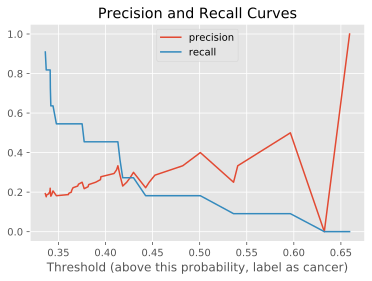

In [84]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, voting_classifer4.predict_proba(X_test)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper center')
plt.xlabel('Threshold (above this probability, label as cancer)');
plt.title('Precision and Recall Curves');

In [85]:
y_predict_v4 = (voting_classifer4.predict_proba(X_test)[:,1] > 0.31)
print('recall:', recall_score(y_test, y_predict_v4))
print('accuracy:', accuracy_score(y_test, y_predict_v4))
print('AUC:', roc_auc_score(y_test, y_predict_v4))

recall: 1.0
accuracy: 0.47674418604651164
AUC: 0.7204968944099379


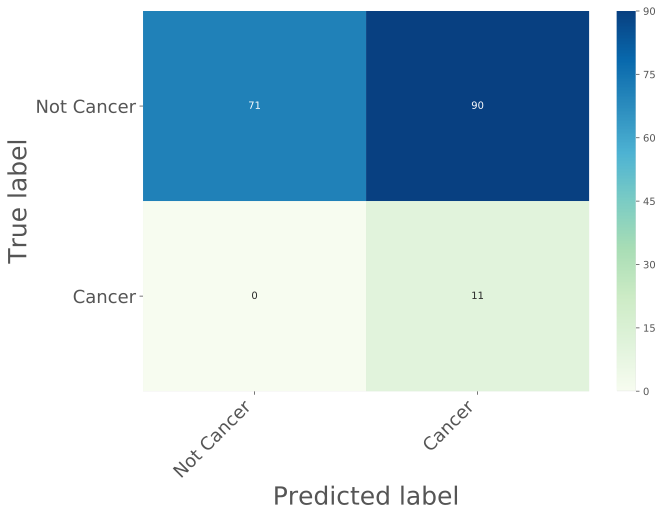

In [86]:
cm = print_confusion_matrix(confusion_matrix(y_test, y_predict_v4), ['Not Cancer', 'Cancer'])
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/cm_vc_08.svg')

ROC AUC score for ET model =  0.8088650479954829
ROC AUC score for Voting classifier =  0.84472049689441


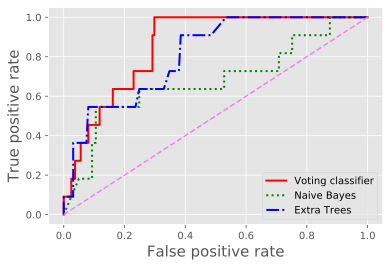

In [139]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, et_model.predict_proba(X_test)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, voting_classifer.predict_proba(X_test)[:,1])

plt.plot(fpr3, tpr3,lw=2, ls='-',c='red',label='Voting classifier')
plt.plot(fpr1, tpr1,lw=2, ls=':',c='green',label='Naive Bayes')
plt.plot(fpr2, tpr2,lw=2, ls='-.',c='blue',label='Extra Trees')



plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', size=15)
plt.ylabel('True positive rate', size=15)
plt.legend(loc='lower right')

print("ROC AUC score for ET model = ", roc_auc_score(y_test, et_model.predict_proba(X_test)[:,1]))
print("ROC AUC score for Voting classifier = ", roc_auc_score(y_test, voting_classifer.predict_proba(X_test)[:,1]>0.37))
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/roc2.svg')

#### Feature importances

RF model

In [89]:
# Get numerical feature importances
feature_list = list(cancer.iloc[:, :30])
importances = list(rf_model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: num_of_preg                    Importance: 0.14
Variable: hormonal_contraceptives_years  Importance: 0.12
Variable: num_of_partner                 Importance: 0.11
Variable: first_intercourse              Importance: 0.11
Variable: hormonal_contraceptives        Importance: 0.11
Variable: age                            Importance: 0.1
Variable: dx_cancer                      Importance: 0.04
Variable: dx_hpv                         Importance: 0.04
Variable: dx                             Importance: 0.04
Variable: smokes_years                   Importance: 0.02
Variable: smokes_packs                   Importance: 0.02
Variable: iud_years                      Importance: 0.02
Variable: stds                           Importance: 0.02
Variable: stds_num                       Importance: 0.02
Variable: smokes                         Importance: 0.01
Variable: iud                            Importance: 0.01
Variable: condylomatosis                 Importance: 0.01
Variable: vulvo

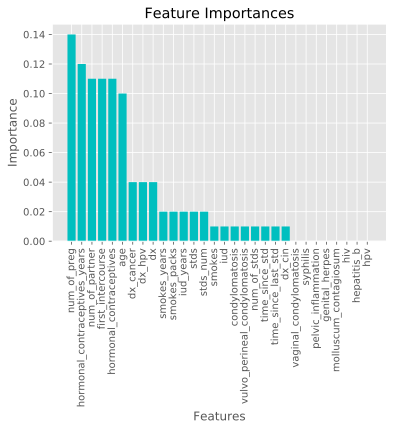

In [90]:
# list of x locations for plotting
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Make a bar chart
plt.bar(sorted_features, sorted_importances, orientation = 'vertical', color='c')

# Tick labels for x axis
plt.xticks(sorted_features, sorted_features, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance') 
plt.xlabel('Features') 
plt.title('Feature Importances')
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/feature_importance.svg')

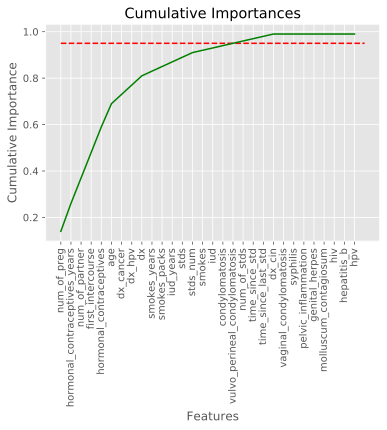

In [91]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Features'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/cumulative_importance.svg')

ET model

In [92]:
# Get numerical feature importances
feature_list = list(cancer.iloc[:, :30])
importances = list(et_model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: hormonal_contraceptives        Importance: 0.14
Variable: num_of_preg                    Importance: 0.12
Variable: num_of_partner                 Importance: 0.1
Variable: first_intercourse              Importance: 0.1
Variable: age                            Importance: 0.09
Variable: hormonal_contraceptives_years  Importance: 0.09
Variable: dx_cancer                      Importance: 0.04
Variable: dx_hpv                         Importance: 0.04
Variable: dx                             Importance: 0.04
Variable: iud                            Importance: 0.03
Variable: smokes                         Importance: 0.02
Variable: smokes_years                   Importance: 0.02
Variable: smokes_packs                   Importance: 0.02
Variable: iud_years                      Importance: 0.02
Variable: stds                           Importance: 0.02
Variable: stds_num                       Importance: 0.02
Variable: condylomatosis                 Importance: 0.01
Variable: vulvo_

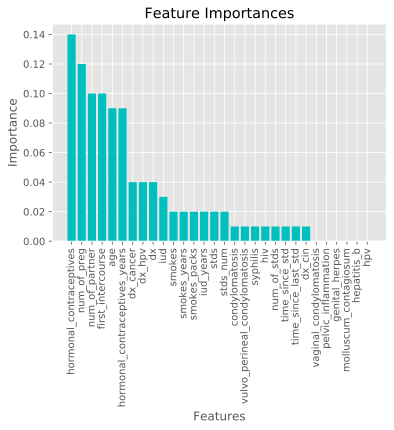

In [93]:
# list of x locations for plotting
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Make a bar chart
plt.bar(sorted_features, sorted_importances, orientation = 'vertical', color='c')

# Tick labels for x axis
plt.xticks(sorted_features, sorted_features, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance') 
plt.xlabel('Features') 
plt.title('Feature Importances')
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/feature_importance_et.svg')

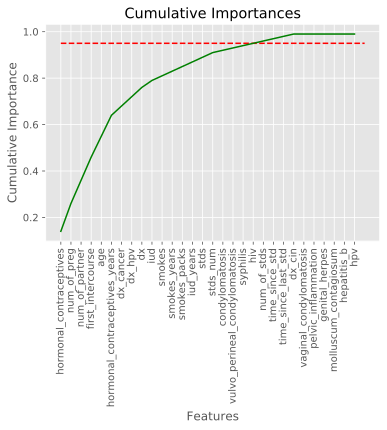

In [94]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Features'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');
plt.savefig('/Users/jsong/Documents/cancer_classification/fig/cumulative_importance_et.svg')